<font size="6"><b>UNet Tutorial:</b></font>
<ol start="0">
<font size="4"><b>0. <a href='#0'>Pre-Tutorial</a></b> 
    <ul>
    <b>0.1</b> <a href='#0.1'>Getting Some Things Set Up</a>  
    </ul>
    <ul>
    <b>0.2</b> <a href='#0.2'>What is a UNet?</a>
    </ul>
   
   
<font size="4"><b>1. <a href='#1'>How Convolutions Work</a></b></font>
    <ul>
    <b>1.1</b> <a href='#1.1'>The Convolution Operation</a>  
    </ul>
    <ul>
    <b>1.2</b> <a href='#1.2'>Convolving an Image</a>
    </ul>
    <ul>
    <b>1.3</b> <a href='#1.3'>Padding</a>
    </ul>
    <ul>
    <b>1.4</b> <a href='#1.4'>Bias Additions and Activations</a>
    </ul>  
    

<font size="4"><b>2. <a href='#2'>How Filters Transform Images</a></b></font>
    <ul>
    <b>2.1</b> <a href='#2.1'>The Horizontal Edge Detector</a>  
    </ul>
    <ul>
    <b>2.2</b> <a href='#2.2'>The Horizontal Edge Detector in Action</a> 
    </ul> 

<font size="4"><b>3. <a href='#3'>The UNet Architecture</a></b></font>
    <ul> 
    <b>3.1</b> <a href='#3.1'>The UNet Structure</a>  
    </ul>
    <ul>
    <b>3.2</b> <a href='#3.2'>Convolutional Layers</a> 
    </ul>
    <ul> 
    <b>3.3</b> <a href='#3.3'>Pooling Layers</a>  
    </ul>
    <ul>
    <b>3.4</b> <a href='#3.4'>Upsampling Layers</a> 
    </ul>
    <ul> 
    <b>3.5</b> <a href='#3.5'>Concatenations</a> 
    </ul>

<font size="4"><b>4. <a href='#4'>A Very Simple Example</a></b></font>
    <ul>
    <b>4.1</b> <a href='#4.1'>The Data/Problem</a>  
    </ul>
    <ul>
    <b>4.1</b> <a href='#4.2'>The Architecture</a>  
    </ul>
    <ul>
    <b>4.2</b> <a href='#4.3'>Conv Block #1</a>  
    </ul>
    <ul>
    <b>4.3</b> <a href='#4.4'>Conv Block #2</a> 
    </ul>
    <ul> 
    <b>4.4</b> <a href='#4.5'>UpConv Block #1</a> 
    </ul>
    <ul> 
    <b>4.5</b> <a href='#4.6'>UpConv Block #2</a>  
    </ul>
<font size="4"><b>5. <a href='#5'>Interpreting Filters</a></b></font>
    <ul>
    <b>4.1</b> <a href='#5.1'>A Real-World Example</a>  
    </ul>
    <ul>
    <b>4.2</b> <a href='#5.2'>Activations</a>  
    </ul>
    <ul>
    <b>4.3</b> <a href='#5.3'>Deeper Layers</a> 
    </ul>
</ol>

<font size="5">**0. Pre-Tutorial**</font>
<a id='#0'></a>

Before we start, let's check that the GPU is ready to go if we have one, and import packages that we'll need, and talk about the motivations behind using a U-Net

<font size="4">**0.1 Some Setup**
<a id='#0.1'></a>


Import other packages we'll need

In [6]:
!pip install -q keras
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

from PIL import Image

from matplotlib import animation
from IPython.display import display, HTML
from IPython.display import Image as Im

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'ffmpeg' # ffmpeg might need to be installed on your computer 
                                                   # (it did on mine) and can be done with pip install 
                                                   # or conda install
matplotlib.rcParams["animation.html"] = "html5"

<font size="4">**0.2 What is a UNet?**</font>
<a id='#0.2'></a>

You might be wondering: what exactly is a UNet? Why would I want to use one? How is it different from other convolutional neural nets? So we'll start by giving a bit of motivation for why UNets are so useful.

<a id='#1'></a>
<font size="5">**1. How Convolutions Work**</font>

UNets are a type of convolutional neural network (CNN), so understanding how convolutions work is fundamental to understanding how these networks work. In this section, we briefly go over how to perform convolutions and the building blocks of a convolutional layer in a CNN. While I cover all the basics here, this is meant as more of a refresher. I recommend my tutoral $\color{red}{mYtUtoRiaL}$ for a more in-depth look at how CNN's work in general.

<font size="4">**1.1 The Convolution Operation**</font>
</a>

First, we need to cover exactly what a "convolution" means. The building blocks of convolutions are essentially dot products over matricies - we multiply the values in a matrix by the corresponding values in another matrix, then add the values together to get a number.

Let's define matricies A and B, then take the dot product between them.

17


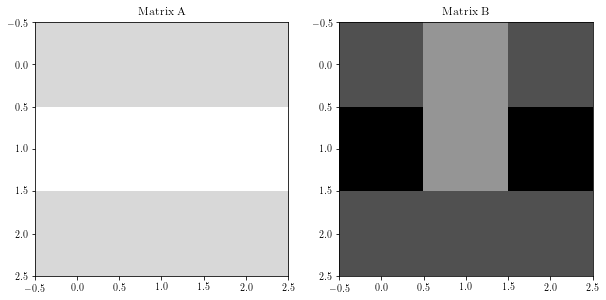

In [3]:
a = np.array([[1,1,1],[0,0,0],[1,1,1]])
b = np.array([[3,2,3],[4,2,4],[3,3,3]])

# to visualize the matricies
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
ax1.imshow(a, vmin=0, vmax=4, cmap="Greys"), ax1.set_title("Matrix A")
ax2.imshow(b, vmin=0, vmax=4, cmap="Greys"), ax2.set_title("Matrix B")

print(np.sum(a*b)) # since a/b are arrays, a*b is element-wise multiplication

Note that, this is different than doing matrix multiplication, which would result in another matrix, rather than just one number.

Really, we want to think of this operation as giving us some linear combination of a matrix. If we want a linear combination of matrix X with values *x1,x2,x3, ... x9*, we can define some matrix A with values *a,b,c, ... i*, such that:

\begin{equation*}
y = \begin{bmatrix}a&b&c\\d&e&f\\g&h&i\end{bmatrix} * \begin{bmatrix}x_1&x_2&x_3\\x_4&x_5&x_6\\x_7&x_8&x_9\end{bmatrix} = (a \times x_1) + (b \times x_2) + (c \times x_3) + (d \times x_4) + (e \times x_5) + (f \times x_6) + (g \times x_7) + (h \times x_8) + (i \times x_9)
\end{equation*}

Then, we can interpret the values in matrix A (*a,b,c, ... i*) as **weights**, each of which decides how strong the contribution from matrix X's values (*x1,x2,x3, ... x9*) should be.

**<font size="4"> 1.2 Convolving an Image**</font>
<a id='#1.2'></a>

When we convolve an image, we simply perform this operation over and over again, on each pixel of an image. So, matrix A would be our matrix of weights, and matrix X is a matrix of pixel values, where the center value is our current pixel of interest. Convolving an image means performing this operation on every pixel of the image, then replacing its value with the one that is given by our matrix dot product. In this way, the image becomes another version of itself - one where each pixel is some linear combination of the pixels that were around it:

\begin{equation*}
\color{red}{x_{5,new}} = \begin{bmatrix}a&b&c\\d&e&f\\g&h&i\end{bmatrix} \times \begin{bmatrix}x_1&x_2&x_3\\x_4&\color{red}{x_5}&x_6\\x_7&x_8&x_9\end{bmatrix} = (a \times x_1) + (b \times x_2) + (c \times x_3) + (d \times x_4) + (e \times x_5) + (f \times x_6) + (g \times x_7) + (h \times x_8) + (i \times x_9)
\end{equation*}

In convolutional network applications, we typically call this matrix of weights a **filter**. In other applications that use convolutions, it may also be called a **kernel**.

Let's use matrix A from before, this time to convolve a simple, 5x5 image. The image we are going to convolve is shown below:

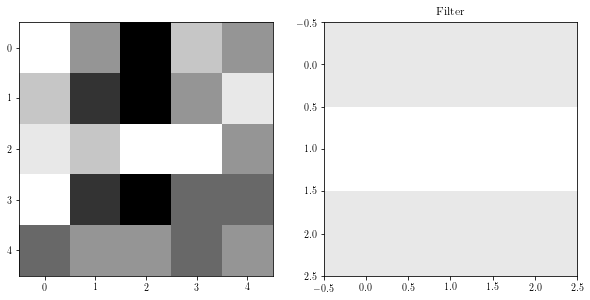

In [4]:
im = np.array([[0,3,6,2,3],
               [2,5,6,3,1],
               [1,2,0,0,3],
               [0,5,6,4,4],
               [4,3,3,4,3]])

# show the image we'll convolve, and the filter we'll convolve it with
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
ax1.imshow(im, cmap="Greys"), plt.title("Starting Image")
ax2.imshow(a, cmap="Greys",vmin=0,vmax=6), plt.title("Filter")

conved_im = np.zeros((3,3)) # we'll replace these as we get the new values

The first step is to take the 3x3 block in the upper left of our image, and multiply that by our weights:

Text(0.55,0.6,'new image so far')

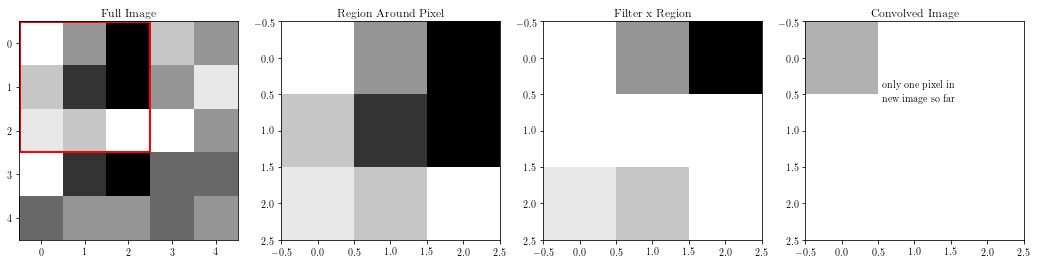

In [5]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)
ax1.imshow(im, cmap = "Greys"), ax1.set_title("Full Image")
ax1.add_patch(matplotlib.patches.Rectangle((-.48,-.48),2.98,2.98,fill=False,color='red',lw=2)) #show region to convolve

ax2.imshow(im[0:3,0:3],cmap="Greys"), ax2.set_title("Region Around Pixel")
ax3.imshow(im[0:3,0:3]*a,cmap="Greys",vmin=0,vmax=6), ax3.set_title("Filter x Region")

conved_im[0][0] = np.sum(im[0:3,0:3]*a)
ax4.imshow(conved_im,cmap="Greys",vmin=0,vmax=29), ax4.set_title("Convolved Image") #here, I prematurely set vmax to what the maximum of conved_im
plt.annotate("only one pixel in", (.55,.4))                                         #will be, otherwise scaling will change as it plots
plt.annotate("new image so far", (.55,.6))

We can see, that because our filter was a row of ones, a row of zeros, then another row of ones, when we apply this filter to our region, the middle row becomes zeros, while the top and bottom rows of the region are unchanged. So, the sum of Filter X Region which creates our new pixel is really just the sum of the top and bottom rows of the region. 

Next, let's move over one pixel, and do the same thing:

Text(0.95,0.7,'now, 2 pixels')

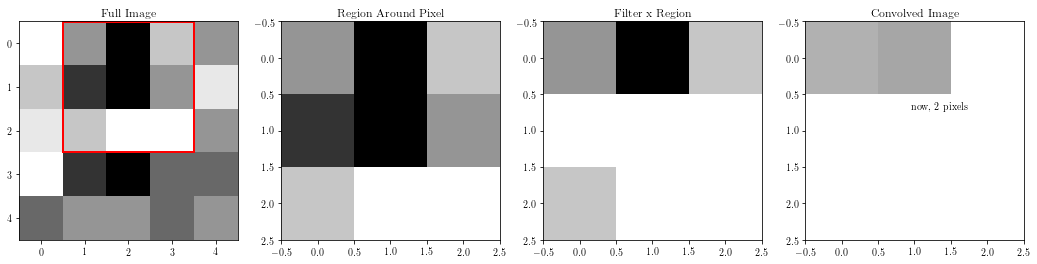

In [10]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)
ax1.imshow(im, cmap = "Greys"), ax1.set_title("Full Image")
ax1.add_patch(matplotlib.patches.Rectangle((.5,-.48),3,2.98,fill=False,color='red',lw=2)) #show region to convolve

ax2.imshow(im[0:3,1:4],cmap="Greys", vmin=0, vmax=6), ax2.set_title("Region Around Pixel")
ax3.imshow(im[0:3,1:4]*a,cmap="Greys",vmin=0,vmax=6), ax3.set_title("Filter x Region")

conved_im[0][1] = np.sum(im[0:3,1:4]*a)
ax4.imshow(conved_im,cmap="Greys",vmin=0,vmax=29), ax4.set_title("Convolved Image") #here, I prematurely set vmax to what the maximum of conved_im
plt.annotate("now, 2 pixels", (.95,.7))                                             #will be, otherwise scaling will change as it plots

We can keep moving it over, and filling in the pixels of this "new version" of our image:

In [7]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)

display_ims = []
conved_im = np.zeros((3,3)) # reset this
for i in range(conved_im.shape[0]):
  for j in range(conved_im.shape[1]):
    im1 = ax1.imshow(im, cmap = "Greys",animated=True)
    ax1.set_title("Full Image")
    im1 = ax1.add_patch(matplotlib.patches.Rectangle((-.48+j,-.48+i),3,3,fill=False,color='red',lw=2)) #show region to convolve

    im2 = ax2.imshow(im[i:i+3,j:j+3],cmap="Greys", vmin=0, vmax=6, animated=True)
    ax2.set_title("Region Around Pixel")
    im3 = ax3.imshow(im[i:i+3,j:j+3]*a,cmap="Greys",vmin=0,vmax=6, animated=True)
    ax3.set_title("Filter x Region")

    conved_im[i][j] = np.sum(im[i:i+3,j:j+3]*a)
    im4 = ax4.imshow(conved_im,cmap="Greys",vmin=0,vmax=29, animated=True) #here, I prematurely set vmax to what the maximum of conved_im
    ax4.set_title("Convolved Image")                                       #will be, otherwise scaling will change as it plots

    display_ims.append([im1, im2, im3, im4])

ani = animation.ArtistAnimation(fig, display_ims, interval=1000, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

**<font size="4"> 1.3 Padding**</font>
<a id='#1.3'></a>

You'll notice that this convolution reduced our image size: while we started with a 5x5 image, our convolved version was only 3x3. This is because we're only able to fit a 3x3 filter onto a 5x5 image, 3x3 times. We aren't able to make "new" pixels out of the ones on the border of the image - our filter can't fit.
For this reason, we usually **pad** images before we convolve them - or add values all around the border of the image. Padding ensures two important things:


1.   <font size="2.5">That the image isn't downsized by a convolution
2.   <font size="2.5">That pixels on the outer edges "count" as much as pixels in the middle. That is - that they're convolved over as many times as pixels closer to the center of the image.

There are many different choices for padding, each with their own unique advantages, but the most common/universal (and the only one we'll discuss here) is **valid**, **zero** padding. **Valid** means that we add whatever padding we need in order to keep the image the same size. **Zero** just means that the values we add along the borders are all zeros.


If we valid zero-pad the image we were just using, we would get:

(<matplotlib.image.AxesImage at 0x182b2f45f8>, Text(0.5,1,'Padded Image'))

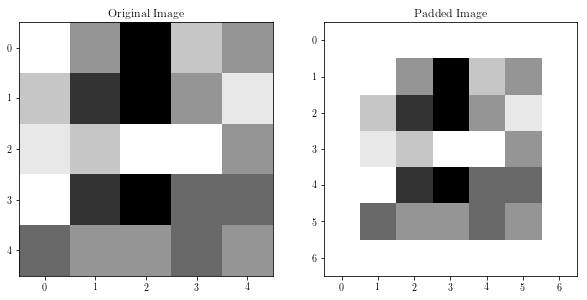

In [9]:
padded_im = np.pad(im, pad_width = (1,1), mode="constant", constant_values=0)

# show the image we'll convolve, and the filter we'll convolve it with
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
ax1.imshow(im, cmap="Greys"), ax1.set_title("Original Image")
ax2.imshow(padded_im, cmap="Greys",vmin=0,vmax=6), ax2.set_title("Padded Image")

We can see, if we re-do the convolution we did to this image in the last section, now with the padded image, that pixels on the edge of the image are also convolved over, and the image size is preserved:

In [ ]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)

display_ims = []
conved_im = np.zeros((5,5)) # now, we'll have 5x5 pixels to fill in
for i in range(conved_im.shape[0]):
  for j in range(conved_im.shape[1]):
    im1 = ax1.imshow(padded_im, cmap = "Greys",animated=True)
    ax1.set_title("Full Image")
    im1 = ax1.add_patch(matplotlib.patches.Rectangle((-.48+j,-.48+i),3,3,fill=False,color='red',lw=2)) #show region to convolve

    im2 = ax2.imshow(padded_im[i:i+3,j:j+3],cmap="Greys", vmin=0, vmax=6, animated=True)
    ax2.set_title("Region Around Pixel")
    im3 = ax3.imshow(padded_im[i:i+3,j:j+3]*a,cmap="Greys",vmin=0,vmax=6, animated=True)
    ax3.set_title("Filter x Region")

    conved_im[i][j] = np.sum(padded_im[i:i+3,j:j+3]*a)
    im4 = ax4.imshow(conved_im,cmap="Greys",vmin=0,vmax=29, animated=True) #here, I prematurely set vmax to what the maximum of conved_im
    ax4.set_title("Convolved Image")                                       #will be, otherwise scaling will change as it plots

    display_ims.append([im1, im2, im3, im4])

ani = animation.ArtistAnimation(fig, display_ims, interval=1000, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

We can see that the 3x3 region that we convolved before remains the same in both images, but when we pad the image, we also get information about the edge pixels that before we weren't going over.

Valid padding means padding in order to maintain image size. In our example above, this means we just had to add a border of single-pixel width to our image. In general though, the size of the border you need to add will depend on a few parameters. The parameters that determine the size after you perform a convolution are:


*   **n**: the size of the input image (assumed square, so it's nxn)
*   **f**: the size of the filter (assumed square, so it's fxf)
*   **s**: the **stride**, or how much you move the filter over before you do the next convolution. In our above examples, we've always used s=1, but in general, s can be any number that will still make the filter fit evenly inside the image. We will assume that you use the same stride along all of the image dimensions.
*   **p**: the width of the padding to be added, assumed the same amount will be added all around the image.

Then, the output dimension of the image will be:

\begin{equation*}
n_{out} \times n_{out} = \frac{n - f + 2p}{s} + 1
\end{equation*}

So, depending on the image size, filter size, and stride selected, you can determine the width of the padding that will need to be added to keep $n_{out} = n$.


**<font size="4"> 1.4 Adding Bias and Activations**</font>
<a id='#1.4'></a>

Before we go on, we need to talk about two other fundamental steps that happen after we convolve an image, which are the final building blocks of what happens in a convolutional layer of neural network. First, we need to talk about bias parameters, then, we'll talk about the activtion step.

We've already talked about how we can intepret each step of a convolution as replacing a pixel with a linear combination of it and the pixels around it. But a classic linear combination has the format:

\begin{equation*}
y = m_1x_1 + m_2x_2 + m_3x_3 + ... + b
\end{equation*}

And so far, we haven't added b. We refer to this extra parameter as the **bias**, it's a single value that get's added to every pixel of the image after the image has been convolved. You need a bias for sort of the same reason that you need b when you fit a line: because it can act to shift the entire image one way, in a way that otherwise can be impossible given just the values $\times$ weights.

Beacuse the bias is just a single number added to every pixel, it's a very simple augmentation of the image:

(<matplotlib.image.AxesImage at 0x182b5450f0>,
 Text(0.5,1,'Convolved Image + (b = -10)'))

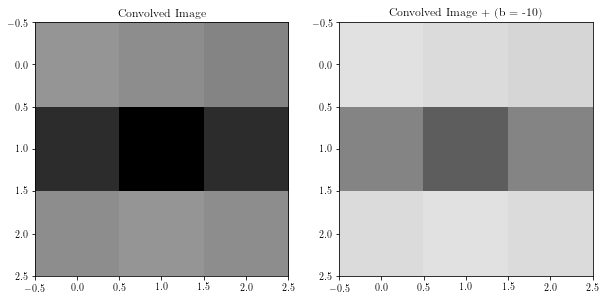

In [10]:
bias = -10
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
ax1.imshow(conved_im, cmap="Greys", vmin=-5, vmax=29), ax1.set_title("Convolved Image")
biased_im = conved_im + bias
ax2.imshow(biased_im, cmap="Greys", vmin=-5, vmax=29), ax2.set_title("Convolved Image + (b = %d)" %bias)

In the above example, we can see that adding the bias dimmed the entire image.

The other step that happens after the convolution step in a convolutional layer is the activation. In the activation step, the image is subject to a function, so each pixel of the image is changed according to that function. In convolutional neural networks, the most common of these functions is ReLU (Rectified Linear Units), which looks like:
\begin{equation*}
ReLU(x) = max(0,x)
\end{equation*}
So, when an image is passed through the ReLU activation, each pixel becomes either 0 (if the value was negative) or remains the same (if the value was 0 or positive).
An image passed through this activation will look like:



(<matplotlib.image.AxesImage at 0x182b497c50>, Text(0.5,1,'Relu-ed Image'))

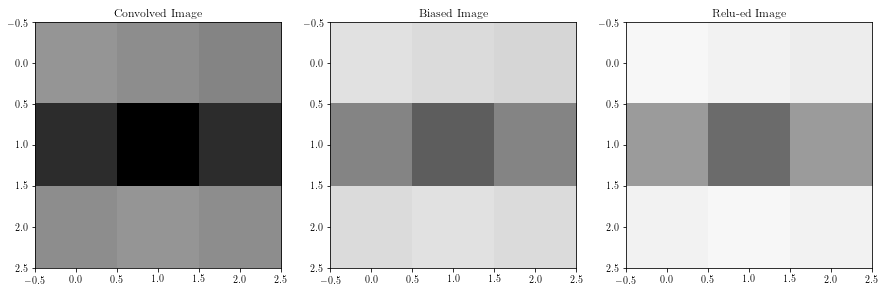

In [11]:
fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.add_subplot(1,3,1), fig.add_subplot(1,3,2), fig.add_subplot(1,3,3)
ax1.imshow(conved_im, cmap="Greys", vmin=-5, vmax=29), ax1.set_title("Convolved Image")
ax2.imshow(biased_im, cmap="Greys", vmin=-5, vmax=29), ax2.set_title("Biased Image")
relu_im = np.maximum(0,biased_im)
ax3.imshow(relu_im, cmap="Greys", vmin=0, vmax=29), ax3.set_title("Relu-ed Image")

When we added the bias to our image, some of our pixels became negative. That means that, after we applied the activation function, these pixels actually became zero-valued, meaning our final image now has some areas of whitespace that weren't there before.

It may seem as though this activation function merely removes information: pixels that previously had value are now becoming zeroed-out, now lending us no information about the image. For a more detailed explanation as to why activation functions are so important (as well as an explanation of the advantages and disadvantages of different choices for the activation function), I recommend $\color{red}{mY oTheR tUToRiAl}$. However, these are the main reasons why we include the activation step:


*   Dying gradients
*   prevent weights from blowing up



<a id='#1'></a>
<font size="5">**2. Interpreting Filters**</font>

The point, really, of a UNet, is to learn the weights of the filters, and the biases, that transform an image and allow us to augment that image into another image. So, we may want to attempt to look at the filters and determine the ways that it might be transforming our image and helping to learn patterns. 

**<font size="4"> 2.1 The Horizontal Edge Detector**</font>
<a id='#2.1'></a>

Some filters, such as the **horizontal edge detector** are fairly easily intepretable in the ways that they tranform an image. We'll take a look at the horizontal edge detector below.

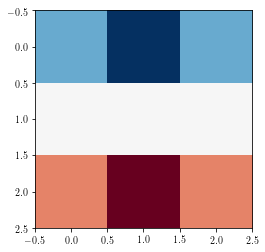

In [12]:
horiz_edge_filter = np.array([[ 1,  2,  1],
                              [ 0,  0,  0],
                              [-1, -2, -1]])

plt.imshow(horiz_edge_filter, cmap = 'RdBu')

This filter is comprised of: a row of positive values, a row of zero values, and a row of negative values.
It may not be immediately obvious how this can pick out horizontal edges, but consider the case of an image with a very simple horizontal edge:

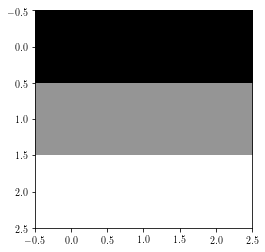

In [13]:
horiz_edge_im = np.array([[ 1, 1, 1],
                          [ 0, 0, 0],
                          [ -1, -1, -1]])

plt.imshow(horiz_edge_im, cmap = 'Greys')

If we convolve this image with this filter (that is, take the sum of the element-wise products of these two 3x3 matricies) we will get a single number:

In [14]:
conved_val = np.sum(horiz_edge_filter*horiz_edge_im)
print("The new pixel value would be:", conved_val)

The new pixel value would be: 8


If instead, this image had been of a vertical edge. Then, when we check what value the convolution gives us, we intead get:


The new pixel value would be: 0


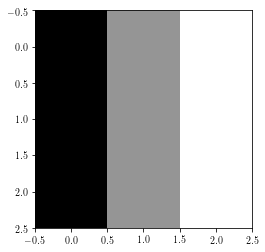

In [15]:
vert_edge_im = np.array([[ 1, 0, -1],
                         [ 1, 0, -1],
                         [ 1, 0, -1]])

plt.imshow(vert_edge_im, cmap = 'Greys')

conved_val = np.sum(horiz_edge_filter*vert_edge_im)
print("The new pixel value would be:", conved_val)

We can see that the structure of the filter is that it's symmetric along its horizontal axis. That is, the row of positive values is mirrored by a row of negative values at the bottom of the filter. This means that, any portion of an image which it is applied to, which is also symmetric along its horizontal axis, will give us a value of 0, because the positive and negatives will cancel out.

\begin{equation*}
\begin{bmatrix}1&2&1\\0&0&0\\-1&-2&-1\end{bmatrix} \times \begin{bmatrix}a&b&c\\a&b&c\\a&b&c\end{bmatrix} = a + 2b + c + 0 -a -2b -c = 0
\end{equation*}

Whereas a portion of an image that changes values along its horizontal axis will give us a nonzero value.

Note that, the values in the center row of the image never matter, because the center row of the filter is all zeros.

**<font size="4"> 2.2 The Horizontal Edge Detector in Action**</font>
<a id='#2.2'></a>

You may notice that an image like the one below, which you would identify as a horizontal line, will not get identified by this filter, because 

*   It's horizontally symmetric, and
*   Every element-wise multiplication includes a zero.

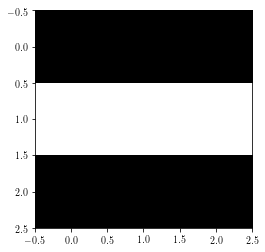

In [16]:
horiz_edge_im = np.array([[ 1, 1, 1],
                          [ 0, 0, 0],
                          [ 1, 1, 1]])

plt.imshow(horiz_edge_im, cmap = 'Greys')

But, in practice, we apply these filters over a larger image, not over an image of matching size, so we'll see that single-pixel edges are still detected by this filter, *just not when the edge is on the center pixel.*

Let's start by loading in an image with some edges, which we'll pass our horizontal edge detector over.


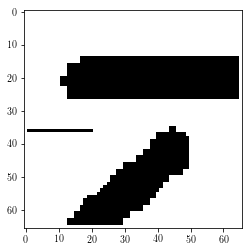

In [19]:
from PIL import Image
im = np.array(Image.open('images/horiz_im.png'))[:,:,2]
im = im/255
im = np.round(im)

im[35][0:20] = 1 #add a single-pixel-width edge, to see if we can detect that too
padded_im = np.pad(im, pad_width = (1,1), mode="constant", constant_values=0)


plt.imshow(padded_im, cmap="Greys")

Now, if we convolve with our filter like we did in Part 1:

<font size="2">**note, this code may take a little time to run*

In [53]:
fig = plt.figure()

# first, get the filter sizes which will help us later
filter_sz = horiz_edge_filter.shape[0]
filter_width = int(np.floor(filter_sz/2))

conv_ims = []
conved_im = padded_im.copy() # set it to a copy, that way we can watch the image transform
for i in range(1, im.shape[0]+1): # from 1-65 instead of 0-64, because we added the padding
  for j in range(1,im.shape[0]+1):
    # first, replace the pixel in the image with the convolved one
    conved_region = padded_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1]*horiz_edge_filter
    conved_im[i,j] = np.sum(conved_region) # replace pixels of the copy with the convolution
    # make an image where the filter is overlayed, too
    filter_im = conved_im.copy()
    filter_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1] = conved_region
    if (i>12 and i<18 and j>10) or (i>50 and i<55 and j>10) or (i>33 and i<37 and j<20): # it would take too long to plot the whole movie, so just do interesting parts
      conv_ims.append([plt.imshow(filter_im, animated=True, cmap = 'RdBu_r',vmin=-2,vmax=2)]) # with filter overlayed
      conv_ims.append([plt.imshow(conved_im, animated=True, cmap = 'RdBu_r',vmin=-2,vmax=2)]) # convolved im result

ani = animation.ArtistAnimation(fig, conv_ims, interval=100, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

There are a few important things to note about this output image:


1.   <font size="2">That the output image contains both $\color{blue}{blue}$ and $\color{red}{red}$ pixels - this filter is able to pick out not only the edge, but the *direction* the edge is going in - that is, higher valued to lower valued pixels or vice versa.
2.   <font size="2">That the single-pixel width edge *is* detected by this filter - and is replaced with these two representations of the edge - where the edge created a border of low to high valued pixels, and where it creates a border of high to low valued pixels.
3.   <font size="2">The perfectly vertical portions of the thick lines are ignored by the filter - but diagonal regions are still detected.


In A U-Net, we want to learn the filters that can transform our image. To do this, we usually must convolve an image with many different filters, with deeper layers applying filters to versions of the image which have already been convolved. So as you can probably guess, the filters of a real U-Net are usually not doing something as simple and interpretable as the horizontal edge detection.

In Section 4, we'll talk more about how to view and interpret the filters of a UNet trained on a real-world example, but for now, we'll take a break to establish exactly what the UNet is doing.

<a id='#1'></a>
<font size="5">**3. The Architecture of a UNet**</font>

Now that we have some foundations about the convolutions that a UNet uses to learn how to transform an image, we'll take a closer look at architecture of a UNet which makes this possible.

**<font size="4"> 3.1 The UNet Structure**</font>
<a id='#3.1'></a>


The basic structure of a UNet looks like this:


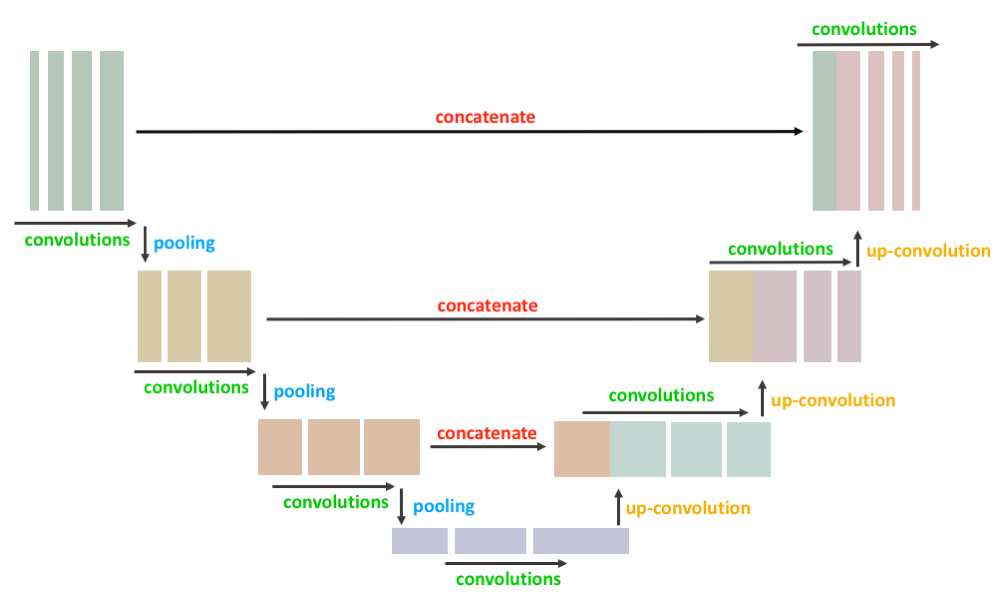

In [22]:
display(Im('images/UNet_Structure.png', width=650, height=400))

U-Nets are named as such because they have this U-like shape, where the input image is first reduced in dimensionality, then increased in dimensionality back to its original size. As you can see, there are 4 main types of operations, which we'll briefly describe here but give a detailed description of in the upcoming subsections:

1.   <font size="2"><font color=#2CC214>**convolutions**</font>: We have already discussed the convolution operation and components of a convolutional layer. In these convolutional portions, the image is convolved repeatedly, with differing (and often differently sized) filters.
2.   <font size="2"><font color=#09DAFF>**pooling**</font>: The image is decreased in dimensionality, by representing regions of a few pixels of the image with only one pixel.
3.   <font size="2"><font color=#FBB300>**up-convolutions**</font>: Sort of the opposite of pooling, one pixel is copied several times to become multiple pixels of the image, in order to increase the image dimensionality.
4.   <font size="2"><font color=red>**concatenations**</font>: An image from a previous part of the network is stacked with the image from the current part of the network

**<font size="4"> 3.2 Convolutions**</font>
<a id='#3.2'></a>

We already talked about convolutions in Section 1. Here, we'll take a look at exactly what makes a convolutional layer, and how those layers stack to extract the information we want from our image.

The basic 

**<font size="4"> 3.3 Pooling**</font>
<a id='#3.3'></a>

The basic idea behind pooling is to reduce the dimensionality of an image, by representing some region of pixels with just one pixel instead.

**Max pooling** is the most common type of pooling, and the type that we will use in our examples in this tutorial. In max pooling, a region of pixels is represented by the maximum-valued pixel within that region.
So, we would represent a region of pixels like this one:

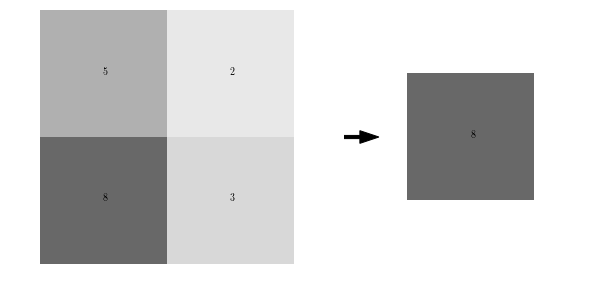

In [23]:
im = np.array([[5,2],  # the region of pixels
               [8,3]])
im_max = np.max(im)    # what pooling would give us

fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)
ax1.axis('off'), ax2.axis('off')

# plot the image region with values 
ax1.imshow(im, cmap="Greys", vmin=0, vmax=12)
for j in range(im.shape[0]):
  for i in range(im.shape[1]):
    ax1.annotate(im[i][j], (j,i))

# plot the resulting region
ax2.imshow(np.pad(np.array([im_max]*4).reshape(2,2),pad_width = (1,1), mode="constant", constant_values=0), # just makes it look nice
           cmap="Greys", vmin=0, vmax=12)
ax2.annotate(im_max, (1.5,1.5))
ax2.arrow(-1.25,1.5,1,0,width=.05,head_width=.2,color='k') #draw an arrow


This would be **2x2** max pooling, because the region of pixels that we replace with a single pixel is size 2x2. We can arbitrarily choose the region size that we use for pooling, but this region is almost always square, and 2x2 is a very typical choice.

2x2 max pooling an entire image involves taking every 2x2 region in the image and replacing it like so:

In [24]:
im = np.array([[0,3,6,2,1,2],
               [2,5,6,3,1,1],
               [1,2,0,0,3,1],
               [2,5,6,4,4,4],
               [2,3,3,4,3,0],
               [0,2,4,5,1,0]])

fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)
ax1.axis('off'),ax2.axis('off')

display_ims = []
pooled_im = np.zeros((3,3))        # output image will have output shape = original shape / 2 for 2x2 pooling
for ind1 in range(pooled_im.shape[0]):
  i = ind1*2         # so that we have an index that moves over by 2 pixels each time, instead of 1
  for ind2 in range(pooled_im.shape[1]):
    j = ind2*2
    im1 = ax1.imshow(im, cmap="Greys", vmin=-1, vmax=10, animated=True)
    for k in range(im.shape[0]):
      for l in range(im.shape[1]):
        im1 = ax1.annotate(im[k][l], (l,k))    # plot the pixel values
    ax1.set_title("Full Image")
    im1 = ax1.add_patch(matplotlib.patches.Rectangle((-.48+j,-.48+i),2,2,fill=False,color='red',lw=2)) #show region of pooling

    pooled_im[ind1][ind2] = np.max(im[i:i+2,j:j+2])
    im2 = ax2.imshow(pooled_im,cmap="Greys",vmin=-1,vmax=10, animated=True)
    ax2.set_title("Pooled Image")                                       

    display_ims.append([im1, im2, ax2.annotate(int(pooled_im[ind1][ind2]), (ind2,ind1))]) #also show pixel values

ani = animation.ArtistAnimation(fig, display_ims, interval=1000, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

We won't discuss any of them in detail here, but there are other types of pooling. **Average pooling**, for instance, takes the average pixel value of a region as the new pixel value.

You might be wondering: what's the advantage of throwing away information?
1.   <font size="2"> Computationally, it's advantageous to remove some information, especially if we can still retain the "most important" information when we do so. In convolutional neural networks in particular, the number of operations we need to perform scales with the size of the image as we convolve it, so reducing the image size can greatly reduce the number of computations we need to do.
2.   <font size="2"> Pooling may help to "sharpen" certain features in the image. Because filters are sort of trying to pick out specific features in an image, choosing the pixel that gave the highest "signal" in a region of an image may help to single out the most important parts of that image.

**<font size="4"> 3.4 Upsampling**</font>
<a id='#3.4'></a>

Upsampling is like the opposite of pooling - instead of shrinking an image by representing a region of pixels with one pixel, we create a region of pixels by copying one pixel into multiple pixels.

In [25]:
im = np.array([[1,3,6],
               [2,5,6],
               [2,4,3]])

fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)

display_ims = []
upsampled_im = np.zeros((6,6))        # output image will have output shape = original shape * 2 for 2x2 upsampling
for i in range(pooled_im.shape[0]):
  ind1 = i*2
  for j in range(pooled_im.shape[1]):
    ind2 = j*2
    im1 = ax1.imshow(im, cmap="Greys", vmin=-1, vmax=10, animated=True)
    for k in range(im.shape[0]):
      for l in range(im.shape[1]):
        im1 = ax1.annotate(im[k][l], (l,k))    # plot the pixel values
    ax1.set_title("Full Image")
    im1 = ax1.add_patch(matplotlib.patches.Rectangle((-.5+j,-.5+i),1,1,fill=False,color='red',lw=2)) #show we're upsampling

    for k in range(ind1,ind1+2):
      for l in range(ind2,ind2+2):
        upsampled_im[k][l] = im[i,j]
        im2 = ax2.imshow(upsampled_im,cmap="Greys",vmin=-1,vmax=10, animated=True)
        display_ims.append([im1,im2,ax2.text(l,k,int(upsampled_im[k][l]))]) # plot the pixel values too
    ax2.set_title("Upsampled Image")                                       

ani = animation.ArtistAnimation(fig, display_ims, interval=600, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

So, you can see that even though the upsampled image looks identical to the original, it actually has dimensions 6x6 instead of 3x3, and 4 times the number of pixels.

**<font size="4"> 3.5 Concatenations**</font>
<a id='#3.5'></a>

con cat

<a id='#1'></a>
<font size="5">**4. A Very Simple UNet Example**</font>

To get a better handle on how exactly these operations work, how they transform our image, and how they change the dimensionality of the image at each step, let's closely investigate an extremely simple example of a UNet.

**<font size="4"> 4.1 The Data/Problem**</font>
<a id='#4.1'></a>

Say we have a simple 8x8 image, made of black and white pixels randomly scattered. And we want to create a UNet to invert the image for us. Our data might look like this:

Text(0.5,1,'out')

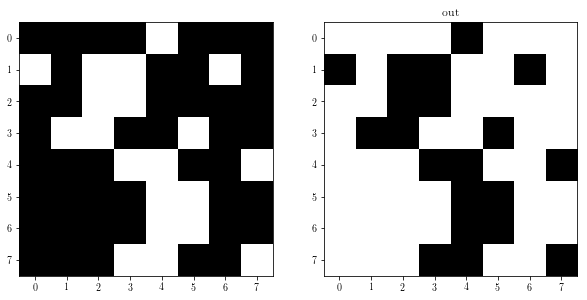

In [27]:
im_in = np.array([[0,0,0,0,1,0,0,0],   # example image in, which we'll also use for testing later
              [1,0,1,1,0,0,1,0],
              [0,0,1,1,0,0,0,0],
              [0,1,1,0,0,1,0,0],
              [0,0,0,1,1,0,0,1],
              [0,0,0,0,1,1,0,0],
              [0,0,0,0,1,1,0,0],
              [0,0,0,1,1,0,0,1]])

im_out = np.abs(1-im_in)              # example image output, just the inversion of the input image

# show our example images
fig=plt.figure(figsize=(10,5))
ax1,ax2 = fig.subplots(1,2)
ax1.imshow(im_in, cmap="Greys_r")
plt.title("in")
ax2.imshow(im_out, cmap="Greys_r")
plt.title("out")


And we can easily generate a dataset of 100 examples:

In [28]:
X_example = []
y_example = []
for i in range(100):
  X_example.append(np.round(np.random.rand(8,8)).reshape(8,8,1))
  y_example.append(np.abs(1-X_example[-1]).reshape(8,8,1))

X_example = np.array(X_example)
y_example = np.array(y_example)

This inversion operation is obviously very simple: It takes one line of code and 2 operations (a subtraction and an absolute value) to perfectly invert our image. But, because this is a transformation of an image, a very simple UNet should also be able to perform this inversion for us, so that's what we'll try to make here.

**<font size="4"> 4.2 The Architecture**</font>
<a id='#4.2'></a>

We'll use a simple UNet, with a few 3x3 filters, to do this inversion. The architecture will look like this:

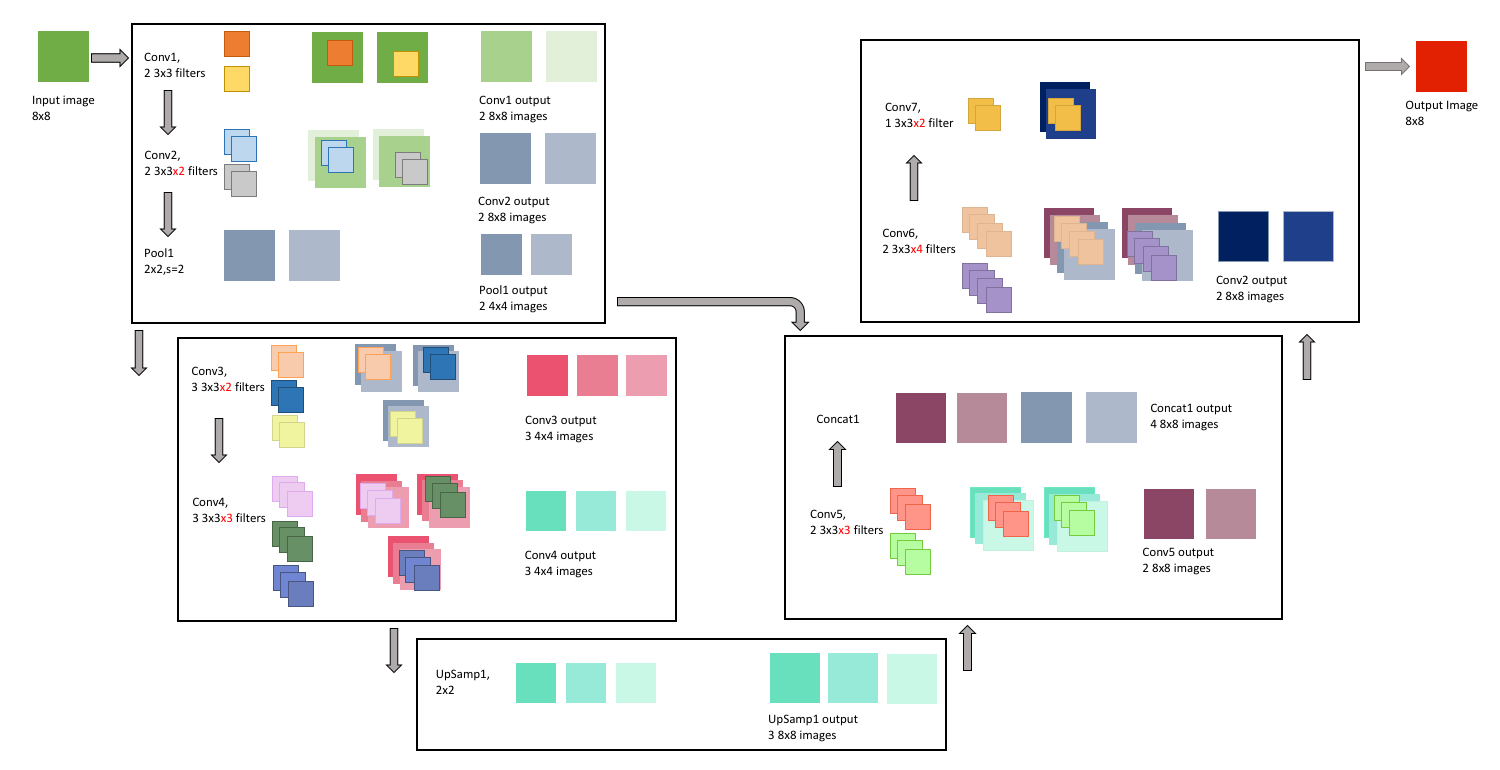

In [29]:
display(Im('images/simple_example_UFormat.png', width=950, height=480))

This might look a little overwhelming right now, but we're going to go through each of the operations that this network will perform in more detail in the upcoming sections.

We will also add layers to the model in keras as we go through them. To start building a model in keras, we just need to start defining our layers. This begins with the input:

In [30]:
input_size = X_example[0].shape    # get the size of the input images, in our case this is 8x8x1
print(input_size) 

inputs = Input(input_size)         # then, we just define an input layer and tell keras to expect images of size 8x8x1

(8, 8, 1)


**<font size="4"> 4.3 Conv Block #1**</font>
<a id='#4.3'></a>

The first convolution block has 3 steps:

1.   <font size="2"> Conv1 2 3x3 filter convolutions
2.   <font size="2"> Conv2 2 3x3 filter convolutions
3.   <font size="2"> Pool1 2x2 pooling



In the first convolution step, the input image is convolved twice: Once with <font color=#e67300>**one 3x3 filter**</font>, and another time with <font color=#ffd633>**another 3x3 filter**</font>. We first pad the input image with zeros, so that the convolved image is 9x9, and the result is **2, 8x8 images**, that we then add our bias to and then pass through the ReLu activation function. Each of these images is a "representation" of the original image. These images are stacked to become two channels of the same image, and the layer output is **1, 8x8x2(channel) image**.

Because we have 2 filters, each with 3x3 weights, and an associated bias for each filter, this means our first layer has a total of:
\begin{equation*}
2\times(3\times3) + 2 = 20
\end{equation*}
learnable parameters.

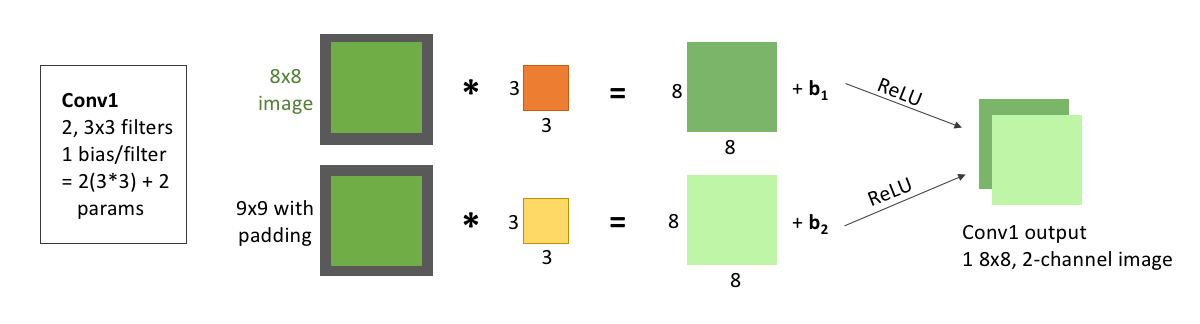

In [31]:
display(Im('images/layers/conv1.png', height=270, width=1000))

We can add this to the model:

In [32]:
conv1 = Conv2D(filters = 2,   # here, we tell the layer we want to use 2 filters
               kernel_size = (3,3),  # the filters are of size 3x3
               activation = 'relu',    # we want to use the ReLU activation function
               padding = 'same',     # same padding means the output size will equal the input size(before padding)
               kernel_initializer = 'he_normal')(inputs)  # we'll initialize the weights with the He normal distribution. We also
                                                          # need to tell this layer what the input to it will be, which is the input
                                                          # layer (inputs)

The next convolution step, takes the output from the first convolution step, and again convolves it twice: Once with <font color=#79a6d2>**one 3x3x2 filter**</font>, and another time with <font color=#a6a6a6>**another 3x3x2 filter**</font>. Note that these filters now need to have 2 channels, because the output from the first layer had 2 channels. As we discussed in the previous section, when a 2-channel filter convolves a 2-channel image, the outputs are added together to generate the output. That is, the <font color= #3973ac>**darker blue**</font> filter convolves the <font color=#8cd98c>**lighter green**</font> channel of the image, and the <font color=#8cb3d9>**lighter blue**</font> filter convolves the <font color=#4b9b5f>**darker green**</font> image. Then, the two channel outputs are added together to create the <font color=#9875a3>**darker purple**</font> image generated from the convolution. The same, of course, happens with the grey filter and the image, generating the <font color=#d9b3e6>**lighter purple**</font>, the second of our two output images.

As with the first convolution layer, we pad the input image with zeros, add a bias after the convolution, and pass the images through the ReLu activation function. These output images are again stacked to become two channels of the same image, making the layer output **1, 8x8x2(channel) image**.

Because we have 2 filters, each with 3x3x2 weights, and an associated bias for each filter, this means this second layer has a total of:
\begin{equation*}
2\times(3\times3\times2) + 2 = 38
\end{equation*}
learnable parameters.

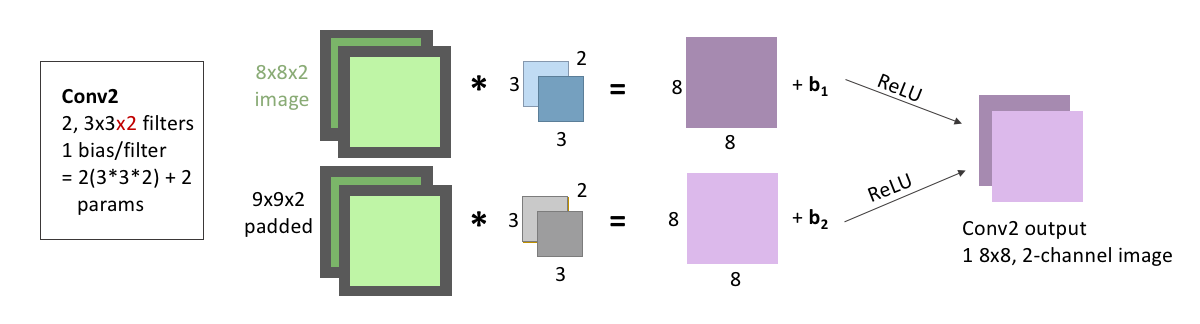

In [33]:
display(Im('images/layers/conv2.png', height=270, width=1000))

We add this to our model, the same way we added the first convolution:

In [34]:
conv2 = Conv2D(filters = 2,   # 2 filters again
               kernel_size = (3,3),  # size 3x3 filters. Keras is smart, so we don't need to tell it that these filters need to have 2
                                     # channels; it will know that because it will know that the input to the layer has 2 channels
               activation = 'relu', padding = 'same',    # we'll be keeping the activation, padding, and initializer the same for all
               kernel_initializer = 'he_normal')(conv1)  # of our layers. But note, the input to this layer was now the output from
                                                         # conv1

The last step in this convolution block is pooling, where we downsize our image by applying 2x2 pooling to it.

There are no learnable parameters in a pooling step, but it's important to note that we *do not* pool across channels - our **8x8x2** output becomes **4x4x2**, because the two channels are each pooled seperately and remain stacked.

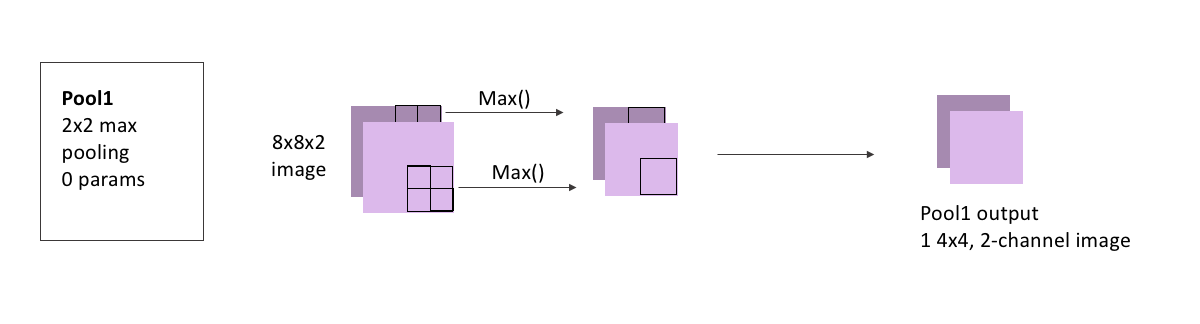

In [35]:
display(Im('images/layers/pool1.png', height=270, width=1000))

Adding a pooling layer to our model is also straightforward with Keras:

In [36]:
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)   # we just need to tell it the size of the region to pool,
                                                # and that we're pooling the output from conv2

**<font size="4"> 4.4 Conv Block #2**</font>
<a id='#4.4'></a>

The second convolution block mimics the first, but we'll increase the number of filters:

1.   <font size="2"> Conv3 has 3 3x3 filter convolutions
2.   <font size="2"> Conv4 has 3 3x3 filter convolutions

We also won't pool here, as the image is already small enough, and the next step will be to re-increase the image size.



For Conv3, the input image is convolved three times: with 3 filters that each have size 3x3, and 2 channels because our output from the pooling layer had 2 channels. As always, we first pad the input image with zeros, add our bias after the convolution, and pass through the ReLu activation function. These images are stacked to become three channels of the same image, and the layer output is **1, 4x4x3(channel) image**.

Because we have 3 filters, each with 3x3x2 weights, and an associated bias for each filter, this means this layer has a total of:
\begin{equation*}
3\times(3\times3\times2) + 3 = 57
\end{equation*}
learnable parameters.

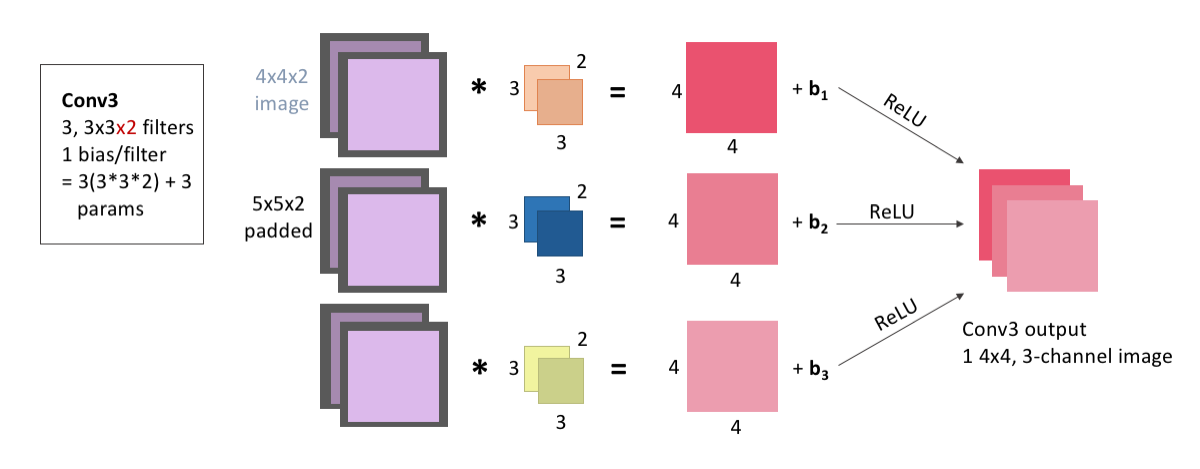

In [37]:
display(Im('images/layers/conv3.png', height=370, width=1000))

Adding this to our model:

In [38]:
conv3 = Conv2D(filters = 3, kernel_size = (3,3),  #again, we don't need to tell it that we'll need 2-channel filters
               activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

For Conv4, the input image is convolved three times: with 3 filters that each have size 3x3, and 3 channels because our output from the Conv3 layer had 3 channels (because it was convolved with 3 filters). We pad the input image with zeros, add our bias after the convolution, and pass through the ReLu activation function. These images are stacked to become three channels of the same image, and the layer output is **1, 4x4x3(channel) image**.

Because we have 3 filters, each with 3x3x3 weights, and an associated bias for each filter, this means this layer has a total of:
\begin{equation*}
3\times(3\times3\times3) + 3 = 84
\end{equation*}
learnable parameters.

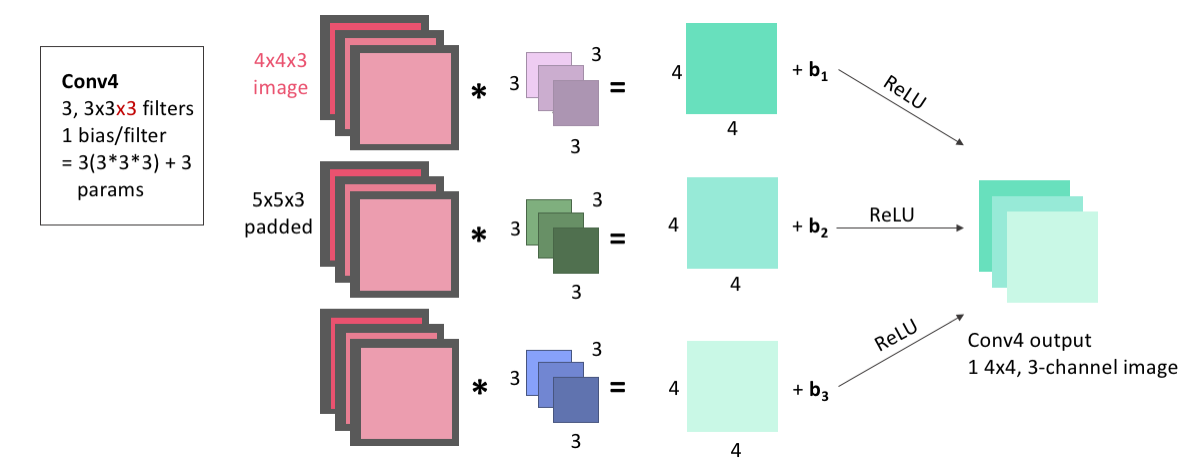

In [39]:
display(Im('images/layers/conv4.png', height=370, width=1000))

Again, this is easy to add to the model:

In [40]:
conv4 = Conv2D(filters = 3, kernel_size = 3,  # if you just give kernel_size a single number, it assumes a square filter of that dimension
               activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

**<font size="4"> 4.5 UpConv Block #1**</font>
<a id='#4.5'></a>

con cat

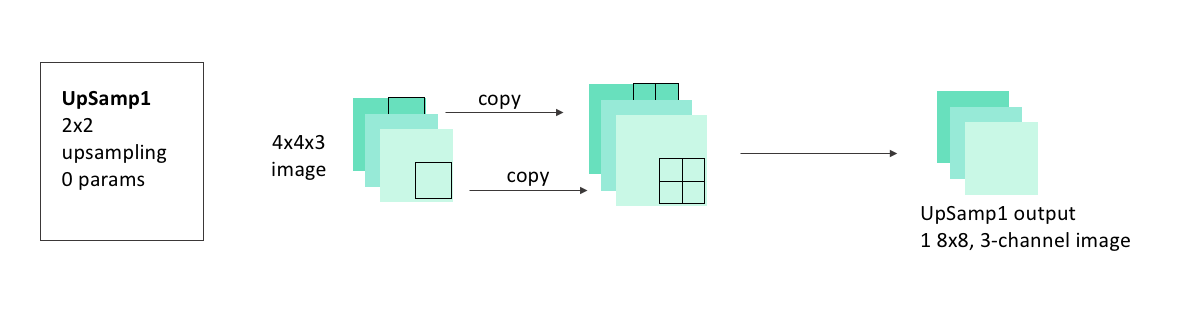

In [41]:
display(Im('images/layers/upsamp1.png', height=270, width=1000))

In [44]:
up1 = UpSampling2D(size = (2,2))(conv4)

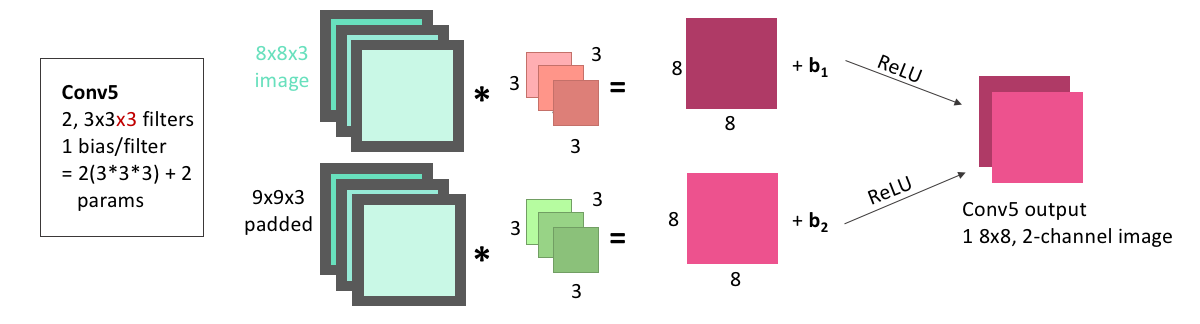

In [45]:
display(Im('images/layers/conv5.png', height=270, width=1000))

In [46]:
conv5 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up1)

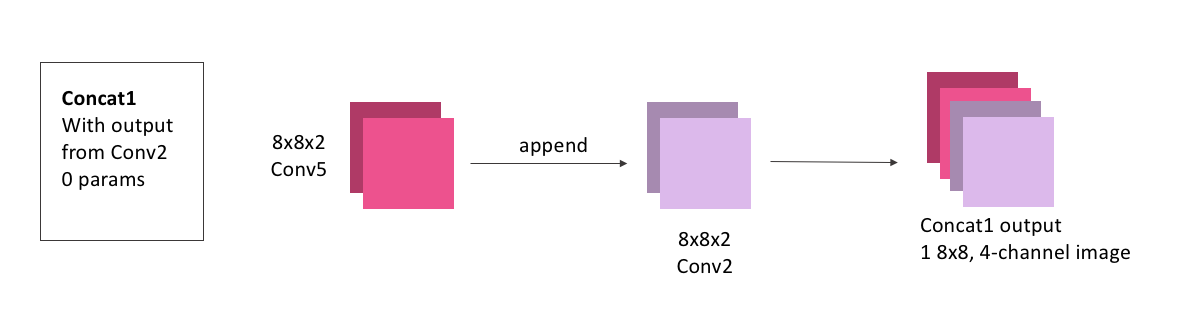

In [47]:
display(Im('images/layers/concat1.png', height=270, width=1000))

In [48]:
concat1 = concatenate([conv2,conv5], axis = 3)

**<font size="4"> 4.6 UpConv Block #2**</font>
<a id='#4.6'></a>

con cat

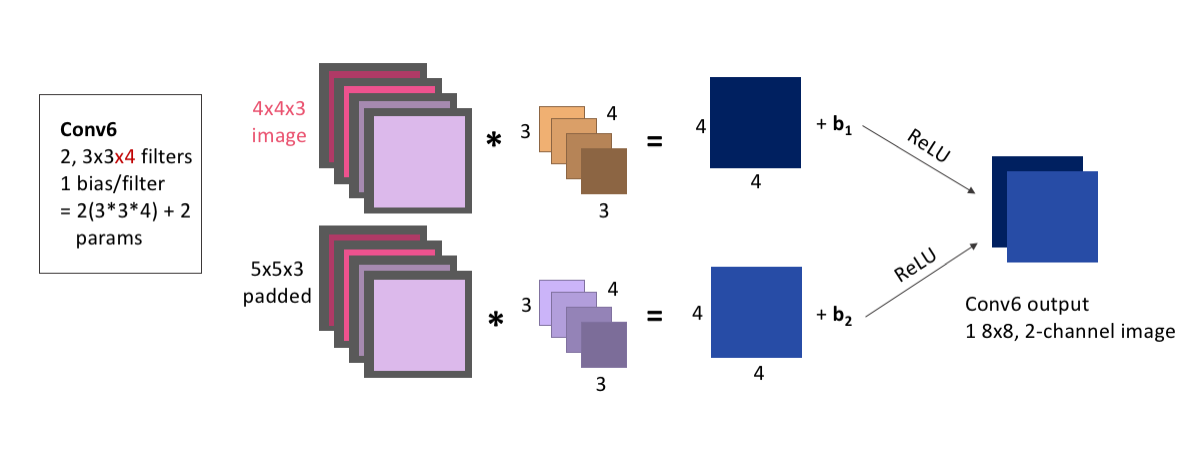

In [50]:
display(Im('images/layers/conv6.png', height=370, width=1000))

In [51]:
conv6 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat1)

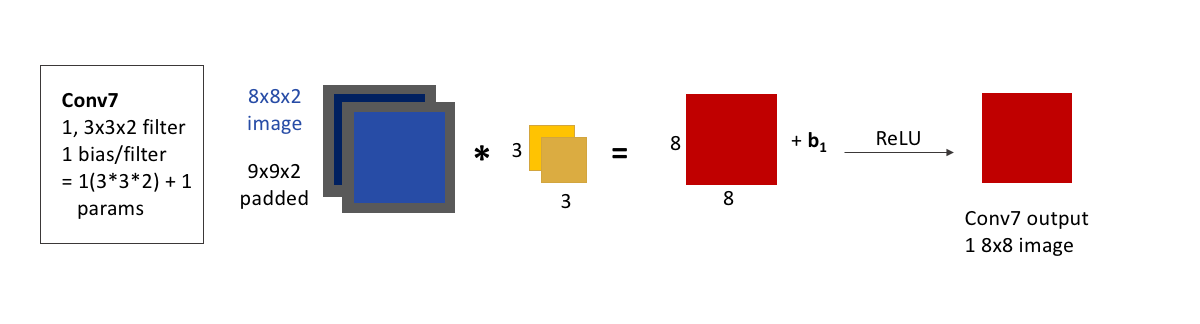

In [52]:
display(Im('images/layers/conv7.png', height=270, width=1000))

In [ ]:
conv7 = Conv2D(1, 3, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv6)

<a id='#1'></a>
##<font size="5">** extra stuff for now **



```
# This is formatted as code
```

**Get the data from Google Drive (and optionally augment it)**


In [ ]:
input_path = '/content/gdrive/My Drive/UNet_Tutorial/data/ims'
output_path = '/content/gdrive/My Drive/UNet_Tutorial/data/labels'

rotation_angles = [90,180,270] # set degrees to rotate by, leave [] if no augmentation
mirror_angles = [Image.TRANSPOSE,Image.FLIP_LEFT_RIGHT,Image.FLIP_TOP_BOTTOM] #set mirror types

sz = 512 #image sizes (one-dimension specified, images must be square)
n_crops = 8
cropped_sz = int(sz/n_crops)
sz = cropped_sz

X = []
for file in np.sort(os.listdir(input_path)):
  full_im = Image.open('%s/%s' %(input_path, file))
  for i in range(n_crops):
    for j in range(n_crops):
      box = (i*cropped_sz,j*cropped_sz,(i+1)*cropped_sz,(j+1)*cropped_sz)
      im = full_im.crop(box)
      X.append(np.array(im).reshape(sz,sz,1))
      for angle in rotation_angles:
        rotated_im = im.rotate(angle)
        X.append(np.array(rotated_im).reshape(sz,sz,1))
      for angle in mirror_angles:
        mirror_im = im.transpose(angle)
        X.append(np.array(mirror_im).reshape(sz,sz,1))

y = []
for file in np.sort(os.listdir(output_path)):
  full_im = Image.open('%s/%s' %(output_path, file))
  for i in range(n_crops):
    for j in range(n_crops):
      box = (i*cropped_sz,j*cropped_sz,(i+1)*cropped_sz,(j+1)*cropped_sz)
      im = full_im.crop(box)
      y.append(np.array(im).reshape(sz,sz,1))
      for angle in rotation_angles:
        rotated_im = im.rotate(angle)
        y.append(np.array(rotated_im).reshape(sz,sz,1))
      for angle in mirror_angles:
        mirror_im = im.transpose(angle)
        y.append(np.array(mirror_im).reshape(sz,sz,1))

input_size = X[0].shape
print(input_size)

X = np.array(X)
y = np.array(y)

# scale data to a 0-1 range
X = (X-np.min(X))/(np.max(X)-np.min(X))
y = (y-np.min(y))/(np.max(y)-np.min(y))


**Check that the data looks good**

In [ ]:
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(X[0].reshape(sz,sz),cmap='Greys_r'), plt.title("Input Image")
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(y[0].reshape(sz,sz),cmap='Greys_r'), plt.title("Output Mask")
ax3 = fig.add_subplot(2,4,5)
ax3.imshow(X[1].reshape(sz,sz),cmap='Greys_r'), plt.title("Input Image, Rotated 90")
ax4 = fig.add_subplot(2,4,6)
ax4.imshow(y[1].reshape(sz,sz),cmap='Greys_r'), plt.title("Output Mask, Rotated 90")
ax5 = fig.add_subplot(2,4,3)
ax5.imshow(X[0].reshape(sz,sz),cmap='Greys_r'), plt.title("Input Image")
ax6 = fig.add_subplot(2,4,4)
ax6.imshow(y[0].reshape(sz,sz),cmap='Greys_r'), plt.title("Output Mask")
ax7 = fig.add_subplot(2,4,7)
ax7.imshow(X[4].reshape(sz,sz),cmap='Greys_r'), plt.title("Input Image, Transpose")
ax8 = fig.add_subplot(2,4,8)
ax8.imshow(y[4].reshape(sz,sz),cmap='Greys_r'), plt.title("Output Mask, Transpose")
plt.tight_layout()

print("We now have %d pieces of data" %len(X))

**The U-Net**

In [ ]:
inputs = Input(input_size)
conv1 = Conv2D(36, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(36, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#drop5 = Dropout(0.5)(conv5)

#up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#merge6 = concatenate([drop4,up6], axis = 3)
#conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(36, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(36, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(36, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy'])

model.summary()


i=0
for file in os.listdir('/content/gdrive/My Drive/UNet_Tutorial/'):
  if '.' in file and '.png' not in file:
    os.remove('/content/gdrive/My Drive/UNet_Tutorial/%s' %file)

In [ ]:
from keras.utils import plot_model
plot_model(model)

**If we want to watch training as it happens, we need to edit a few things**

In [ ]:
import time
t0 = time.time()

# Train
n_epochs = 18
tracked_images = [50] #data we're trying to track

if i==0:
    loss_hist = []
    passed_epochs = 0
else:
    model = load_model('/content/gdrive/My Drive/UNet_Tutorial/model.h5')
    loss_hist = np.loadtxt('/content/gdrive/My Drive/UNet_Tutorial/loss_history.txt').tolist()
    passed_epochs = len(loss_hist)
for i in range(n_epochs):
  print("Epoch %d" %(i+passed_epochs+1))
  model_history = model.fit(X, y, epochs = 1, verbose = 1,batch_size=6)
  loss_hist.append(model_history.history['loss'])
  for image in tracked_images:
    current_im = model.predict(X[image:image+1]).reshape(sz,sz)
    np.savetxt('/content/gdrive/My Drive/UNet_Tutorial/im_%d_e_%d.txt' %(image, i+passed_epochs+1), current_im)
  model.save("/content/gdrive/My Drive/UNet_Tutorial/model.h5")

np.savetxt('/content/gdrive/My Drive/UNet_Tutorial/loss_history.txt', loss_hist)

t1 = time.time() - t0
print("Time Elapsed: ",t1)

**Plot model perfomance and training progress**

In [ ]:
plt.plot(np.arange(len(loss_hist)),loss_hist)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

from matplotlib import animation
from IPython.display import display, Image, HTML

data_num = tracked_images[0]
starting = X[data_num].reshape(sz,sz)
predicted = model.predict(X[data_num:data_num+1]).reshape(sz,sz)
true = y[data_num].reshape(sz,sz)

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,3,1)
plt.imshow(starting,cmap='Greys_r'), plt.title("input")

ax1 = plt.subplot(1,3,2)
plt.imshow(predicted,cmap='Greys_r'), plt.title("predicted")

ax1 = plt.subplot(1,3,3)
plt.imshow(true,cmap='Greys_r'), plt.title("output")
plt.tight_layout()

ims = []
tracked_im = data_num
fig = plt.figure()
for file in os.listdir('/content/gdrive/My Drive/UNet_Tutorial/'):
    if 'im_%d' %tracked_im in file:
      im = plt.imshow(np.loadtxt('/content/gdrive/My Drive/UNet_Tutorial/%s' %file), animated=True, cmap = 'Greys_r')
      ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())
    

**Plot what happens with weights**

In [ ]:
from keras import models
from PIL import Image

im = Image.open('/content/gdrive/My Drive/UNet_Tutorial/data/test_input.png')

data_num = 190
im = X[data_num].reshape(sz,sz)

img_in = np.array(im).reshape(1,sz,sz,1)
#im = Image.open('/content/gdrive/My Drive/UNet_Tutorial/data/test_output.png')
#img_out = np.array(im).reshape(sz,sz,1)

layer_outputs = [layer.output for layer in model.layers[1:]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

activations = activation_model.predict(img_in) 


In [ ]:
print(len(activations))

for layer_num in range(2):#(len(activations)):
  layer_activation = activations[layer_num]
  fig = plt.figure(figsize = (15,2*np.ceil(layer_activation.shape[-1]/9)))
  plt.title("%s Activations" %model.layers[layer_num+1].name)
  plt.axis('off')
  for filter_num in range(layer_activation.shape[-1]):
    ax = fig.add_subplot(np.ceil(layer_activation.shape[-1]/9), 9, filter_num+1)
    ax.matshow(layer_activation[0, :, :, filter_num], cmap='Greys_r')
    plt.axis('off')
  plt.tight_layout()

**Now, visualize the filters (at least the first set, after that it's pretty impossible)**

In [ ]:
for layer in model.layers[1:2]:
  if "conv" in layer.name:
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    fig = plt.figure(figsize=(15,2*int(np.ceil(filters.shape[-1]/10))))
    for i in range(filters.shape[-1]):
      ax = fig.add_subplot(2*np.ceil(filters.shape[-1]/10),10,i+1)
      plt.imshow(filters[:,:,:,i].reshape(filters.shape[0],filters.shape[1]),cmap='RdBu')
      plt.axis('off')
    plt.tight_layout()
  

**First, let's look at how filters work in general by looking at a simple edge-detection filter**

In [ ]:
def padding_for_kernel(kernel):
    image_shape = kernel.shape[:2]
    # We only handle kernels with odd dimensions so make sure that's true.
    # (The "center" pixel of an even number of pixels is arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]

def add_padding(image, kernel):
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)),
                  mode='constant', constant_values=0)
horiz_edge_filter = np.array([[ 1,  2,  1],
                              [ 0,  0,  0],
                              [-1, -2, -1]])
im = np.array(Image.open('/content/gdrive/My Drive/UNet_Tutorial/horiz_im.png'))[:,:,2]
im = im/255
im = np.round(im)

padded_im = add_padding(im,horiz_edge_filter)
padded_amount = im.shape[0]
h_pad, w_pad = padding_for_kernel(horiz_edge_filter)
filter_sz = horiz_edge_filter.shape[0]
filter_width = int(np.floor(filter_sz/2))

conv_ims = []
fig2 = plt.figure()
conved_im = padded_im.copy()
for i in range(h_pad, padded_amount+1):
  for j in range(w_pad, padded_amount+1):
    conved_region = padded_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1]*horiz_edge_filter
    conved_im[i,j] = np.sum(conved_region)
    filter_im = conved_im.copy()
    filter_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1] = conved_region
    if (i>12 and i<17) or (i>50 and i<53):
      conv_ims.append([plt.imshow(filter_im, animated=True, cmap = 'RdBu_r',vmin=-2,vmax=2)])
      conv_ims.append([plt.imshow(conved_im, animated=True, cmap = 'RdBu_r',vmin=-2,vmax=2)])

ani = animation.ArtistAnimation(fig2, conv_ims, interval=100, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())


In [ ]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1,3,1)
plt.imshow(im,cmap = 'RdBu_r',vmin=-2,vmax=2)
ax = fig3.add_subplot(1,3,2)
plt.imshow(horiz_edge_filter,cmap = 'RdBu_r',vmin=-2,vmax=2)
ax = fig3.add_subplot(1,3,3)
plt.imshow(conved_im,cmap = 'RdBu_r',vmin=-2,vmax=2)

**There are a few filters that look like they could be interesting, so we can take a closer look at them. In particular, filters  , , and  look like they might be doing something we can intepret**



In [ ]:
from scipy.ndimage import convolve

im = X[data_num].reshape(sz,sz)
filter_nums = [27,21,14]
names = ['diag edge','high variability','dark spots']

l1_filters, l1_biases = model.layers[1].get_weights()
chosen_filter = l1_filters[:,:,:,filter_num].reshape(l1_filters.shape[0],l1_filters.shape[1])

fig = plt.figure(figsize=(15,5))
for i in range(len(filter_nums)):
  ax = fig.add_subplot(1,len(filter_nums),i+1)
  filt = l1_filters[:,:,:,filter_nums[i]].reshape(l1_filters.shape[0],l1_filters.shape[1])
  plt.imshow(filt,cmap='RdBu')
  plt.colorbar()
  plt.title(names[i])

fig = plt.figure(figsize=(15,5))
for i in range(len(filter_nums)):
  ax = fig.add_subplot(1,len(filter_nums),i+1)
  plt.imshow(im,cmap='Greys_r')

fig = plt.figure(figsize=(15,5))
for i in range(len(filter_nums)):
  ax = fig.add_subplot(1,len(filter_nums),i+1)
  filt = l1_filters[:,:,:,filter_nums[i]].reshape(l1_filters.shape[0],l1_filters.shape[1])
  plt.imshow(np.maximum(convolve(im, filt, mode='constant', cval=0)[1:-1,1:-1],0),cmap='Greys_r')




In [ ]:
fig = plt.figure(figsize=(15,5))
ims = []
for i in range(1):
  ax = fig.add_subplot(1,len(filter_nums),i+1)
  filt = l1_filters[:,:,:,filter_nums[i]].reshape(l1_filters.shape[0],l1_filters.shape[1])
  ims.append([ax.imshow(im,cmap='Greys_r')])
  ims.append([ax.imshow(np.maximum(convolve(im, filt, mode='constant', cval=0)[1:-1,1:-1],0),cmap='Greys_r')])

ani = animation.ArtistAnimation(fig, ims, interval=1500, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

In [ ]:
fig = plt.figure(figsize=(15,5))
ims = []
for i in range(1,2):
  ax = fig.add_subplot(1,len(filter_nums),1)
  filt = l1_filters[:,:,:,filter_nums[i]].reshape(l1_filters.shape[0],l1_filters.shape[1])
  ims.append([ax.imshow(im,cmap='Greys_r')])
  ims.append([ax.imshow(np.maximum(convolve(im, filt, mode='constant', cval=0)[1:-1,1:-1],0),cmap='Greys_r')])

ani = animation.ArtistAnimation(fig, ims, interval=1500, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

In [ ]:
from scipy.ndimage import convolve

im = X[data_num].reshape(sz,sz)
filter_num = filter_nums[1]

l1_filters, l1_biases = model.layers[1].get_weights()
chosen_filter = l1_filters[:,:,:,filter_num].reshape(l1_filters.shape[0],l1_filters.shape[1])

filter_sz = chosen_filter.shape[0]
im_sz = im.shape[0]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,4,1)
plt.imshow(im, cmap='Greys_r')
plt.title('Input Image')
ax = fig.add_subplot(1,4,2)
convolved_im = convolve(im, chosen_filter, mode='constant', cval=0)
plt.imshow(convolved_im, cmap='Greys_r')
plt.title('Convolved Image')
ax = fig.add_subplot(1,4,3)
relued_im = np.maximum(convolved_im,0)
plt.imshow(relued_im, cmap='Greys_r')
plt.title('ReLu-ed Image')
ax = fig.add_subplot(1,4,4)
activated_im = activations[0][0, :, :, filter_num]
plt.imshow(activated_im, cmap='Greys_r')
plt.imshow(relued_im, cmap='Greys_r')
plt.title('Activated Image')


**Now, we'll watch it in action**

In [ ]:
def padding_for_kernel(kernel):
    image_shape = kernel.shape[:2]
    # We only handle kernels with odd dimensions so make sure that's true.
    # (The "center" pixel of an even number of pixels is arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]

def add_padding(image, kernel):
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)),
                  mode='constant', constant_values=0)
    
padded_im = add_padding(im,chosen_filter)
padded_amount = im.shape[0]
h_pad, w_pad = padding_for_kernel(chosen_filter)
filter_width = int(np.floor(filter_sz/2))

conv_ims = []
fig = plt.figure()
conved_im = padded_im.copy()
for i in range(h_pad, padded_amount+1):
  for j in range(w_pad, padded_amount+1):
    conved_region = padded_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1]*chosen_filter
    conved_im[i,j] = np.sum(conved_region)
    filter_im = conved_im.copy()
    filter_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1] = conved_region
    if (i>3 and i<8) or (i>50 and i<54):
      conv_ims.append([plt.imshow(filter_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
      conv_ims.append([plt.imshow(conved_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])

for i in range(25):
  conv_ims.append([plt.imshow(np.maximum(conved_im,0), animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])

ani = animation.ArtistAnimation(fig, conv_ims, interval=100, blit=True, repeat_delay=5000)
plt.close()

HTML(ani.to_html5_video())

### **An ultra-ultra simple UNet example**

**First, let's look at a really simple, 6x6 input image of a line:**

In [ ]:
im_in = np.array([[0,0,0,0,0,0,0,0],
              [1,0,1,1,0,0,0,0],
              [0,0,1,1,0,0,0,0],
              [0,1,1,0,0,1,0,0],
              [0,0,0,1,1,0,0,1],
              [0,0,0,0,1,1,0,0],
              [0,0,0,0,1,1,0,0],
              [0,0,0,1,1,0,0,1]])

im_out = np.abs(1-im_in)

fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
plt.imshow(im_in, cmap="Greys_r")
plt.title("in")
ax = fig.add_subplot(1,2,2)
plt.imshow(im_out, cmap="Greys_r")
plt.title("out")

X_example = []
y_example = []
for i in range(100):
  X_example.append(np.round(np.random.rand(8,8)).reshape(8,8,1))
  y_example.append(np.abs(1-X_example[-1]).reshape(8,8,1))

X_example = np.array(X_example)
y_example = np.array(y_example)

print(X_example[0].shape)


**We'll make an extremely simple UNet architecture to manipulate some images like this. It'll look something like:**

In [ ]:
from IPython.display import Image, display
display(Image('/content/gdrive/My Drive/UNet_Tutorial/simple_example.png'))

**Which, we can see has a Unet architecture:**

In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/simple_example_UFormat.png'))

**Okay, so here's the Unet in keras:**

In [ ]:
input_size = X_example[0].shape

inputs = Input(input_size)
conv1 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)


up1 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
merge1 = concatenate([conv1,up1], axis = 3)
conv3 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
conv4 = Conv2D(1, 3, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv3)


#conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model_simp = Model(input = inputs, output = conv4)

model_simp.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy'])

model_simp.summary()

**Train it**

In [ ]:
print(X_example.shape)
print(y_example.shape)

import time
t0 = time.time()

# Train
n_epochs = 2000

model_history_simp = model_simp.fit(X_example, y_example, epochs = n_epochs, verbose = 1)

t1 = time.time() - t0
print("Time Elapsed: ",t1)

In [ ]:
plt.plot(np.arange(n_epochs),model_history_simp.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

from matplotlib import animation
from IPython.display import display, Image, HTML

data_num = 0
starting = X_example[data_num].reshape(8,8)
predicted = model_simp.predict(X_example[data_num:data_num+1]).reshape(8,8)
true = y_example[data_num].reshape(8,8)

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,3,1)
plt.imshow(starting,cmap='Greys_r'), plt.title("input")

ax1 = plt.subplot(1,3,2)
plt.imshow(predicted,cmap='Greys_r'), plt.title("predicted")

ax1 = plt.subplot(1,3,3)
plt.imshow(true,cmap='Greys_r'), plt.title("output")
plt.tight_layout()
    

**Let's look at these filters/activations**

In [ ]:
for layer in model_simp.layers:
  if "conv" in layer.name:
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    fig = plt.figure(figsize=(15,2*int(np.ceil(filters.shape[-1]/10))))
    for i in range(filters.shape[-1]):
      ax = fig.add_subplot(2*np.ceil(filters.shape[-1]/10),10,i+1)
      plt.imshow(filters[:,:,:,i][:,:,0],cmap='RdBu')
      plt.axis('off')
    plt.tight_layout()
  

In [ ]:
from keras import models

layer_outputs = [layer.output for layer in model_simp.layers[1:]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model_simp.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(X_example[data_num:data_num+1]) 

for layer_num in range(len(activations)):#(len(activations)):
  layer_activation = activations[layer_num]
  fig = plt.figure(figsize = (15,2*np.ceil(layer_activation.shape[-1]/9)))
  plt.title("%s Activations" %model_simp.layers[layer_num+1].name)
  plt.axis('off')
  for filter_num in range(layer_activation.shape[-1]):
    ax = fig.add_subplot(np.ceil(layer_activation.shape[-1]/9), 9, filter_num+1)
    ax.matshow(layer_activation[0, :, :, filter_num], cmap='Greys_r')
    plt.axis('off')
  plt.tight_layout()

**This one, we can *actually* watch train**

**Let's start by looking at the first block, which is made up of:**


*   A convolution, using **2 3x3** filters on **1** input image.
*   A convolution, using **2 3x3x2** filters on **2** activation images.
*   **2x2** Max pooling of **2** activation images.



**A convolution, using 2 3x3 filters on 1 input image.**

In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/conv1.png'))

In [ ]:
def padding_for_kernel(kernel):
    image_shape = kernel.shape[:2]
    # We only handle kernels with odd dimensions so make sure that's true.
    # (The "center" pixel of an even number of pixels is arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]

def add_padding(image, kernel):
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)),
                  mode='constant', constant_values=0)

fig2 = plt.figure(figsize=(10,5))
plt.title("Conv2D_1")
plt.axis('off')
ax1 = fig2.add_subplot(1,2,1)
plt.title("Channel 1")
ax2 = fig2.add_subplot(1,2,2)
axes = [ax1,ax2]

im = X_example[0].reshape(8,8)

layer_num = 1
filters, biases = model_simp.layers[layer_num].get_weights()
network_ims = []
conved_ims = []
for filt_num in range(filters.shape[-1]):
  ax = axes[filt_num]
  chosen_filter = filters[:,:,:,filt_num][:,:,0]
  filter_sz = chosen_filter.shape[0]
  filter_width = int(np.floor(filter_sz/2))
  padded_im = add_padding(im,chosen_filter)
  padded_amount = im.shape[0]
  h_pad, w_pad = padding_for_kernel(chosen_filter)
  conved_im = padded_im.copy()
  for i in range(h_pad, padded_amount+1):
    for j in range(w_pad, padded_amount+1):
      conved_region = padded_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1]*chosen_filter
      conved_im[i,j] = np.sum(conved_region)
      filter_im = conved_im.copy()
      filter_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1] = conved_region
      if filt_num == 0:
        network_ims.append([ax.imshow(filter_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
        network_ims.append([ax.imshow(conved_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
      else:
        for k in range(filt_num):
          #plts.append(axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1))
          network_ims.append([axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),ax.imshow(filter_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
          network_ims.append([axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),ax.imshow(conved_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
  conved_ims.append(np.maximum(conved_im,0))

for i in range(10):
  network_ims.append([axes[0].imshow(conved_ims[0], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),axes[1].imshow(conved_ims[1], animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])


ani = animation.ArtistAnimation(fig2, network_ims, interval=200, blit=True, repeat_delay=5000)
plt.close()

HTML(ani.to_html5_video())


In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/conv2.png'))

In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/pool1.png'))

**The second block is made up of:**


*   A convolution, using **3 3x3x2** filters on **2** activation images.
*   A convolution, using **3 3x3x3** filters on **3** activation images.
*   **2x2** Max pooling of **3** activation images.



In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/conv3.png'))

In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/conv4.png'))

**The third block is made up of:**


*   **2x2** upsampling of **3** activation images.

*   A convolution, using **3 3x3x3** filters on **3** activation images.
*   A concatenation of layer **Conv5** to layer **Conv2**.



In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/upsamp1.png'))

In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/conv5.png'))

In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/concat1.png'))

**The fourth block is made up of:**


*   A convolution, using **2 3x3x4** filters on **4** activation images.
*   A convolution, using **1 3x3x2** filter on **2** activation images.



In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/conv6.png'))

In [ ]:
display(Image('/content/gdrive/My Drive/UNet_Tutorial/layers/conv7.png'))

In [ ]:
fig3 = plt.figure(figsize=(10,5))
plt.title("Conv2D_2")
ax1 = fig3.add_subplot(1,2,1)
ax2 = fig3.add_subplot(1,2,2)
axes = [ax1,ax2]

#im1 = conved_ims[0][1:-1,1:-1]
#im2 = conved_ims[0][1:-1,1:-1]

im = im2
layer_num = 2
filts, biases = model_simp.layers[layer_num].get_weights()
filters = filts[:,:,1]

network_ims = []
conved_ims = []
for filt_num in range(filters.shape[-1]):
  ax = axes[filt_num]
  chosen_filter = filters[:,:,filt_num]
  filter_sz = chosen_filter.shape[0]
  filter_width = int(np.floor(filter_sz/2))
  padded_im = add_padding(im,chosen_filter)
  padded_amount = im.shape[0]
  h_pad, w_pad = padding_for_kernel(chosen_filter)
  conved_im = padded_im.copy()
  for i in range(h_pad, padded_amount+1):
    for j in range(w_pad, padded_amount+1):
      conved_region = padded_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1]*chosen_filter
      conved_im[i,j] = np.sum(conved_region)
      filter_im = conved_im.copy()
      filter_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1] = conved_region
      if filt_num == 0:
        network_ims.append([ax.imshow(filter_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
        network_ims.append([ax.imshow(conved_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
      else:
        for k in range(filt_num):
          #plts.append(axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1))
          network_ims.append([axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),ax.imshow(filter_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
          network_ims.append([axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),ax.imshow(conved_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
  conved_ims.append(np.maximum(conved_im,0))

for i in range(10):
  network_ims.append([axes[0].imshow(conved_ims[0], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),axes[1].imshow(conved_ims[1], animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])


ani = animation.ArtistAnimation(fig3, network_ims, interval=200, blit=True, repeat_delay=5000)
plt.close()

HTML(ani.to_html5_video())

### extra

In [ ]:
fig3 = plt.figure(figsize=(15,10))
ax1 = fig2.add_subplot(2,2,1)
ax2 = fig2.add_subplot(2,2,2)
ax3 = fig2.add_subplot(2,2,3)
ax4 = fig2.add_subplot(2,2,4)
axes1 = [ax1,ax3]
axes2 = [ax2,ax4]

im1 = conved_ims[0][1:-1,1:-1]
print(im1.shape)
im2 = conved_ims[1][1:-1,1:-1]
print(im2.shape)

layer_num = 2
filts, biases = model_simp.layers[layer_num].get_weights()
network_ims = []
conved_ims = []

filters = filts[:,:,0]
axes = axes1
for filt_num in range(filters.shape[-1]):
  if filt_num == 0:
    im = im1
  else:
    im = im2
  ax = axes[filt_num]
  chosen_filter = filters[:,:,filt_num]
  filter_sz = chosen_filter.shape[0]
  filter_width = int(np.floor(filter_sz/2))
  padded_im = add_padding(im,chosen_filter)
  padded_amount = im.shape[0]
  h_pad, w_pad = padding_for_kernel(chosen_filter)
  conved_im = padded_im.copy()
  for i in range(h_pad, padded_amount+1):
    for j in range(w_pad, padded_amount+1):
      conved_region = padded_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1]*chosen_filter
      conved_im[i,j] = np.sum(conved_region)
      filter_im = conved_im.copy()
      filter_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1] = conved_region
      if filt_num == 0:
        network_ims.append([ax.imshow(filter_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
        network_ims.append([ax.imshow(conved_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
      else:
        for k in range(filt_num):
          #plts.append(axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1))
          network_ims.append([axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),ax.imshow(filter_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
          network_ims.append([axes[k].imshow(conved_ims[k], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),ax.imshow(conved_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
  conved_ims.append(np.maximum(conved_im,0))

#for i in range(10):
#  network_ims.append([axes[0].imshow(conved_ims[0], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),
#                      axes[1].imshow(conved_ims[1], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),
#                      axes[2].imshow(conved_ims[2], animated=True, cmap = 'Greys_r',vmin=0,vmax=1),
#                      axes[3].imshow(conved_ims[3], animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])


ani = animation.ArtistAnimation(fig3, network_ims, interval=200, blit=True, repeat_delay=5000)
plt.close()

HTML(ani.to_html5_video())


In [ ]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)
axes = [ax1,ax2,ax3,ax4]

def padding_for_kernel(kernel):
    image_shape = kernel.shape[:2]
    # We only handle kernels with odd dimensions so make sure that's true.
    # (The "center" pixel of an even number of pixels is arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]

def add_padding(image, kernel):
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)),
                  mode='constant', constant_values=0)


network_ims = []
network_ims.append([ax1.imshow(im_in, animated=True, cmap="Greys_r",vmin=0,vmax=1)])
im_act = []
for layer in model_simp.layers:
  if "conv" in layer.name:
    filters, biases = layer.get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    if layer == model_simp.layers[0]:
      ims = [im_in]
    else:
      ims = im_act

    for filt_num in range(filters.shape[-1]):
      chosen_filter = filters[:,:,:,filt_num][:,:,0]
      filter_sz = chosen_filter.shape[0]
      filter_width = int(np.floor(filter_sz/2))
      for im in ims:
        padded_im = add_padding(im,chosen_filter)
        padded_amount = im.shape[0]
        h_pad, w_pad = padding_for_kernel(chosen_filter)
        conved_im = padded_im.copy()
        for i in range(h_pad, padded_amount+1):
          for j in range(w_pad, padded_amount+1):
            conved_region = padded_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1]*chosen_filter
            conved_im[i,j] = np.sum(conved_region)
            filter_im = conved_im.copy()
            filter_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1] = conved_region
            network_ims.append([plt.imshow(filter_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
            network_ims.append([plt.imshow(conved_im, animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
        for i in range(10):
          network_ims.append([plt.imshow(np.maximum(conved_im,0), animated=True, cmap = 'Greys_r',vmin=0,vmax=1)])
      im_act.append(layer_activation[0, :, :, filt_num])

ani = animation.ArtistAnimation(fig, network_ims, interval=200, blit=True, repeat_delay=5000)
plt.close()

HTML(ani.to_html5_video())